<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import torch
from torch.utils.data.dataset import random_split
from torchaudio import datasets

from dcunet.dcunet import DCUnet10
from utils.data import get_data, preprocess, WrappedDataLoader
from utils.train import train, wsdr_fn

import matplotlib.pyplot as plt
import IPython.display as ipd

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torchaudio\backend\utils.py:64: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  'The interface of "soundfile" backend is planned to change in 0.8.0 to '


In [2]:
print(torch.cuda.is_available())
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

dataset = datasets.VCTK_092(root="data", download=False)

ds_size = len(dataset)
train_i = int(0.1 * ds_size)
train_i += train_i % 2
val_i = int(0.11 * ds_size) - train_i
val_i += val_i % 2
test_i = ds_size - train_i - val_i

train_ds, val_ds, test_ds = random_split(dataset, lengths=[train_i, val_i, test_i],
                                         generator=torch.Generator().manual_seed(42))

batch_size = 1
DEVICE = dev
SAMPLE_RATE = 48000
N_FFT = SAMPLE_RATE * 64 // 1000 + 4
HOP_LENGTH = SAMPLE_RATE * 16 // 1000 + 4

train_dl, val_dl, test_dl = get_data(train_ds, val_ds, test_ds, batch_size)
train_dl = WrappedDataLoader(train_dl, preprocess, HOP_LENGTH, DEVICE)
val_dl = WrappedDataLoader(val_dl, preprocess, HOP_LENGTH, DEVICE)
test_dl = WrappedDataLoader(test_dl, preprocess, HOP_LENGTH, DEVICE)

dcunet10 = DCUnet10(N_FFT, HOP_LENGTH).to(DEVICE)

loss_fn = wsdr_fn
optimizer = torch.optim.Adam(dcunet10.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

True


In [3]:
test_ep_loss = 0.
counter = 0.
for i, (noisy_x, clean_x) in enumerate(val_dl):
#     print(i, len(val_dl))
    # get the output from the model
    noisy_x, clean_x = noisy_x.to(dev), clean_x.to(dev)
#     pred_x = net(noisy_x)

    # calculate loss
    loss = loss_fn(noisy_x, noisy_x, clean_x)
    test_ep_loss += loss.item()

    counter += 1
test_ep_loss /= counter
print(test_ep_loss)

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
  normalized, onesided, return_complex)
E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\functional.py:587: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:602.)
  normalized, onesided, length, return_complex)


-0.6150059844260891


In [15]:
train_losses, test_losses = train(dcunet10, train_dl, val_dl, loss_fn, optimizer, scheduler, 100, dev)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Loss before training:-0.636569
99 / 4388 -0.6345320337950581
199 / 4388 -0.6378327889658099
299 / 4388 -0.6361364915618131
399 / 4388 -0.636651202849577
499 / 4388 -0.6368457455195502
599 / 4388 -0.636792960668446
699 / 4388 -0.6379797224152582
799 / 4388 -0.6372868995344236
899 / 4388 -0.636643260153833
999 / 4388 -0.6370013302510923
1099 / 4388 -0.6367233501877755
1199 / 4388 -0.6367259534127122
1299 / 4388 -0.6369263771132747
1399 / 4388 -0.6369748856017554
1499 / 4388 -0.6371415315507809
1599 / 4388 -0.6373580458799402
1699 / 4388 -0.6374538815709125
1799 / 4388 -0.6375561788752716
1899 / 4388 -0.6375051402399075
1999 / 4388 -0.6372814400157909
2099 / 4388 -0.6374138145432011
2199 / 4388 -0.6375107863183561
2299 / 4388 -0.6372106127009904
2399 / 4388 -0.6370728319761603
2499 / 4388 -0.6371534721953432
2599 / 4388 -0.6372725087984473
2699 / 4388 -0.6371012995887041
2799 / 4388 -0.6371510470709915
2899 / 4388 -0.6370430023722009
2999 / 4388 -0.6371450018747603
3099 / 4388 -0.63713561

  1%|▊                                                                             | 1/100 [14:06<23:16:11, 846.18s/it]

Epoch: 1/100... Loss: -0.636729... Test Loss: -0.636275
99 / 4388 -0.6373494285525698
199 / 4388 -0.6400749722317834
299 / 4388 -0.6382993210518241
399 / 4388 -0.6385737352801445
499 / 4388 -0.6383666074825433
599 / 4388 -0.6389110527173903
699 / 4388 -0.6383887801388644
799 / 4388 -0.6384101994941769
899 / 4388 -0.6380252137995668
999 / 4388 -0.6378682378056768
1099 / 4388 -0.6378308826408352
1199 / 4388 -0.6377781177680626
1299 / 4388 -0.6373356958826841
1399 / 4388 -0.6372573235956919
1499 / 4388 -0.6372852530616215
1599 / 4388 -0.6373454982448623
1699 / 4388 -0.6376884605268509
1799 / 4388 -0.6377232917618129
1899 / 4388 -0.6377265453966371
1999 / 4388 -0.6375722991877523
2099 / 4388 -0.6374776630301655
2199 / 4388 -0.6372087811166018
2299 / 4388 -0.6370249206914026
2399 / 4388 -0.6369793421156758
2499 / 4388 -0.6370285989738265
2599 / 4388 -0.637000878231486
2699 / 4388 -0.637109805474064
2799 / 4388 -0.637190664504502
2899 / 4388 -0.6372405538973458
2999 / 4388 -0.637335469560569

  2%|█▌                                                                            | 2/100 [27:26<22:18:15, 819.34s/it]

Epoch: 2/100... Loss: -0.637467... Test Loss: -0.640731
99 / 4388 -0.6326213184029165
199 / 4388 -0.6349636117118088
299 / 4388 -0.6366641877287607
399 / 4388 -0.6360639249322408
499 / 4388 -0.6350741087195868
599 / 4388 -0.6364532762357906
699 / 4388 -0.6379008710554912
799 / 4388 -0.6373048397492109
899 / 4388 -0.6377418386326218
999 / 4388 -0.6378947612461265
1099 / 4388 -0.637567013664827
1199 / 4388 -0.6369292636878099
1299 / 4388 -0.6370774348760404
1399 / 4388 -0.6373117841764209
1499 / 4388 -0.6372422895247019
1599 / 4388 -0.6370556708646611
1699 / 4388 -0.6374380010026143
1799 / 4388 -0.637340396990572
1899 / 4388 -0.6375306966180485
1999 / 4388 -0.6376488259161872
2099 / 4388 -0.6377534204690214
2199 / 4388 -0.6379472785995678
2299 / 4388 -0.6379107921576697
2399 / 4388 -0.6378484200616338
2499 / 4388 -0.6379228966290496
2599 / 4388 -0.6380530133665686
2699 / 4388 -0.6381433304922366
2799 / 4388 -0.6379852256377964
2899 / 4388 -0.6378414004825238
2999 / 4388 -0.63809123334188

  3%|██▎                                                                           | 3/100 [40:50<21:52:53, 812.10s/it]

Epoch: 3/100... Loss: -0.638438... Test Loss: -0.637212


  3%|██▎                                                                           | 3/100 [41:05<22:08:23, 821.68s/it]


KeyboardInterrupt: 

In [ ]:
xi = iter(val_dl)

In [21]:
x = next(xi)
x_noisy = x[0][0]
x_true = x[1][0]
with torch.no_grad():
    x_pred = dcunet10(x_noisy.unsqueeze(0))
x_pred = x_pred / (x_pred.max() - x_pred.min()) * (x_true.max() - x_true.min())

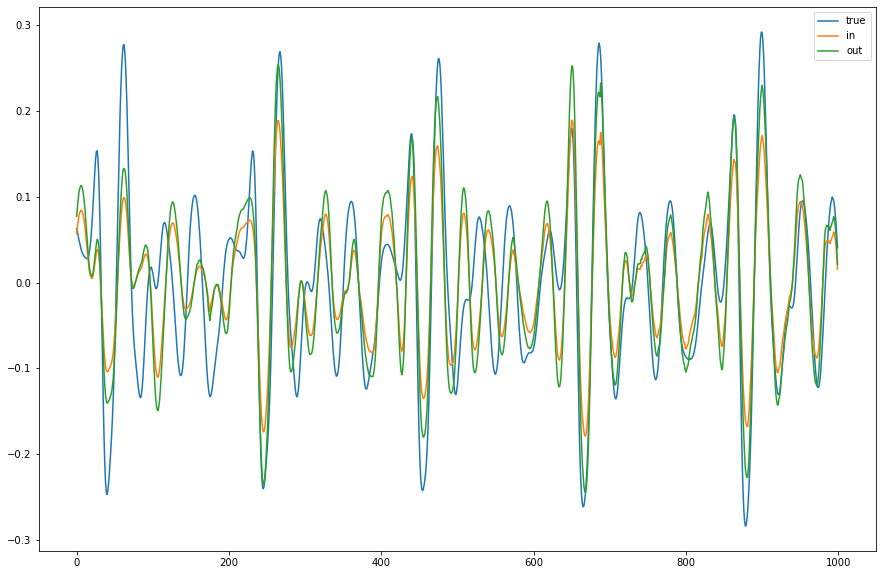

In [22]:
sl = slice(50000, 51000)
plt.figure(figsize=(15,10))
plt.plot(x_true.squeeze().cpu()[sl])

plt.plot(x_noisy.squeeze().cpu()[sl])
plt.plot(x_pred.squeeze().cpu()[sl])

plt.legend(["true", "in", "out"])

In [23]:
display(ipd.Audio(x_noisy.squeeze().cpu(), rate=SAMPLE_RATE));

In [24]:
display(ipd.Audio(x_true.squeeze().cpu(), rate=SAMPLE_RATE));

In [25]:
display(ipd.Audio(x_pred.squeeze().cpu(), rate=SAMPLE_RATE));

In [12]:
from utils.train import wsdr_fn

In [13]:
wsdr_fn(x_noisy.unsqueeze(0), x_noisy.unsqueeze(0), x_true.unsqueeze(0))

tensor(-0.6143, device='cuda:0')

In [14]:
test_ep_loss = 0.
counter = 0.
for i, (noisy_x, clean_x) in enumerate(val_dl):
#     print(i, len(val_dl))
    # get the output from the model
    noisy_x, clean_x = noisy_x.to(dev), clean_x.to(dev)
#     pred_x = net(noisy_x)

    # calculate loss
    loss = loss_fn(noisy_x, noisy_x, clean_x)
    test_ep_loss += loss.item()

    counter += 1
test_ep_loss /= counter
print(test_ep_loss)

-0.6152791957876999
